In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_boston
from sklearn import linear_model
import statsmodels.api as sm

from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    # def __init__(self, *args, **kwargs):
    #     if not "fit_intercept" in kwargs:
    #         kwargs['fit_intercept'] = False
    #     super(LinearRegression, self).__init__(*args, **kwargs)

    def __init__(self):
        super(LinearRegression, self).__init__(fit_intercept=False)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(
                np.diagonal(
                    sse * np.linalg.inv(
                        np.dot(X.T, X)
                    )
                )
            )
        ])

        self.X = X
        self.y = y
        self.se = se
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

    def summary(self):
        columns = ['Estimate', 'Std. Error', 't statistic', 'P value']
        index = self.X.columns
        data = np.array([
            self.coef_,
            self.se[0],
            self.t[0],
            self.p[0]
        ]).T
        
        return pd.DataFrame(data=data, index=index, columns=columns)

In [4]:
housing = fetch_openml(name="house_prices", as_frame=True)
boston = load_boston()

In [5]:
housing_X = housing.data
housing_y = housing.target

housing_X['intercept'] = 1

In [6]:
housing.feature_names.index('GrLivArea')

46

In [7]:
lr = LinearRegression()
lr.fit(housing_X.loc[:, ['GrLivArea', 'intercept']], housing_y)

LinearRegression()

In [8]:
y_pred = lr.predict(housing_X.loc[:, ['GrLivArea', 'intercept']])

In [9]:
lr.summary()

,Estimate,Std. Error,t statistic,P value
GrLivArea,107.130359,2.793621,38.348207,0.000000
intercept,18569.025856,4480.754549,4.144174,0.000036


In [10]:
boston_lr = LinearRegression()

In [11]:
boston_X = boston['data']
boston_y = boston['target']
print(boston['feature_names'])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [12]:
boston_X_df = pd.DataFrame(data=boston_X, columns=boston.feature_names)
boston_X_df['intercept'] = 1

In [13]:
boston_lr.fit(boston_X_df.loc[:, ['LSTAT', 'intercept']], boston_y)

LinearRegression()

In [14]:
boston_lr.summary()

,Estimate,Std. Error,t statistic,P value
LSTAT,-0.950049,0.038733,-24.527900,0.0
intercept,34.553841,0.562627,61.415146,0.0


In [15]:
boston_lr.predict([
    (5, 1),
    (10, 1),
    (15, 1)
])

array([29.80359411, 25.05334734, 20.30310057])

In [16]:
# bostom_X_sm = sm.add_constant(boston_X_df.loc[:, ['LSTAT', 'intercept']])
# est = sm.OLS(boston_y, bostom_X_sm).fit()

boston_lr_sm = sm.OLS(boston_y, boston_X_df.loc[:, ['LSTAT', 'intercept']]).fit()
print(boston_lr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           5.08e-88
Time:                        00:20:34   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LSTAT         -0.9500      0.039    -24.528      0.0

In [17]:
boston_lr_sm.predict([
    [5, 1],
    [10, 1],
    [15, 1]
])

array([29.80359411, 25.05334734, 20.30310057])

Text(0, 0.5, 'medv')

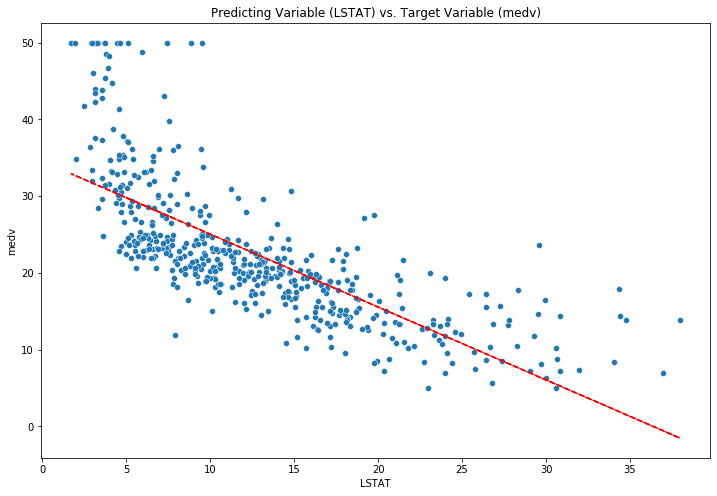

In [18]:
fig = plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=boston_X_df.LSTAT,
    y=boston_y
)
plt.plot(boston_X_df['LSTAT'], boston_lr.predict(boston_X_df.loc[:, ['LSTAT', 'intercept']]), color='r', linestyle='--')
plt.title('Predicting Variable (LSTAT) vs. Target Variable (medv)')
plt.xlabel('LSTAT')
plt.ylabel('medv')

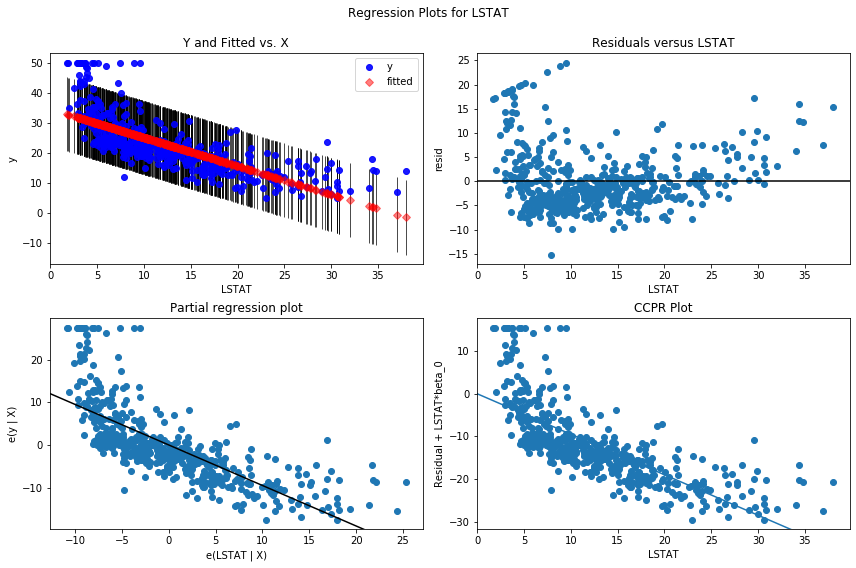

In [19]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(boston_lr_sm, 'LSTAT', fig=fig)

Text(0, 0.5, 'Residuals')

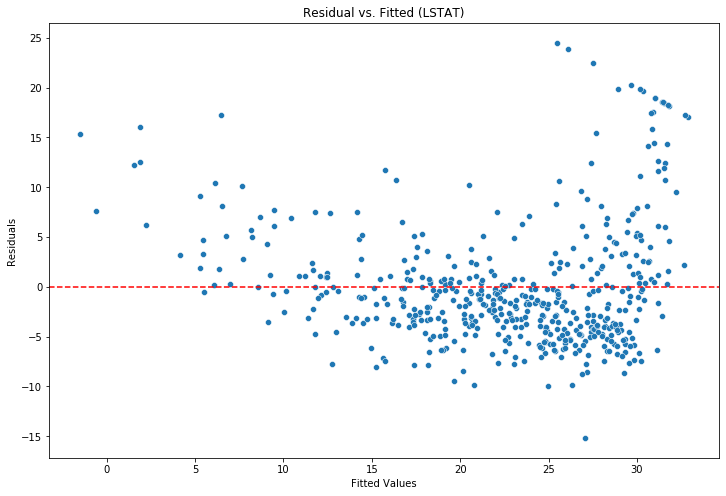

In [20]:
boston_y_pred = boston_lr_sm.predict(boston_X_df.loc[:, ['LSTAT', 'intercept']])

# Residuals vs. Fitted Values
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=boston_y_pred,
    y=(boston_y - boston_y_pred)
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs. Fitted (LSTAT)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

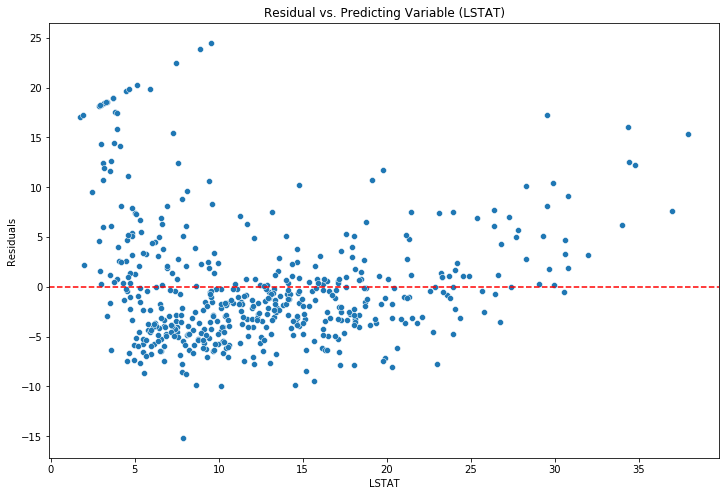

In [21]:
# Residuals vs. Predicting Variables
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=boston_X_df['LSTAT'],
    y=(boston_y - boston_y_pred)
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs. Predicting Variable (LSTAT)')
plt.xlabel('LSTAT')
plt.ylabel('Residuals')

Text(0, 0.5, 'Sample Quantiles')

<Figure size 864x576 with 0 Axes>

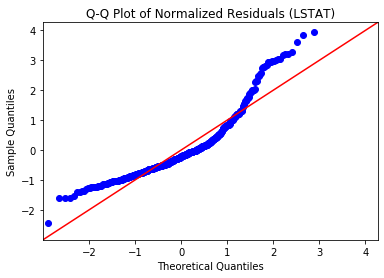

In [22]:
res = boston_lr_sm.resid

fig = plt.figure(figsize=(12, 8))
sm.qqplot(res, fit=True, line='45')
plt.title('Q-Q Plot of Normalized Residuals (LSTAT)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

In [23]:
LSTAT_LEN = len(boston_X_df.LSTAT)
LSTAT_MEAN = boston_X_df.LSTAT.mean()
LSTAT_SS = ((boston_X_df.LSTAT - LSTAT_MEAN)**2).sum()
RES = boston_y - boston_y_pred
LEV = (1/LSTAT_LEN) + (boston_X_df.LSTAT - LSTAT_MEAN)**2 / LSTAT_SS
STD_ERR = np.sqrt((boston_y - boston_y_pred)**2 / LSTAT_LEN)

In [24]:
standardized_residuals = RES / (STD_ERR*np.sqrt(1-LEV))

Text(0, 0.5, 'Count of Normalized (Standardized) Residuals')

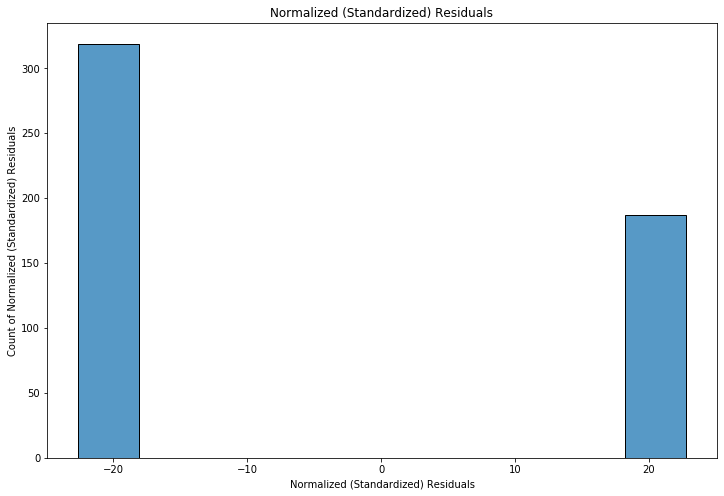

In [25]:
plt.figure(figsize=(12, 8))
sns.histplot(standardized_residuals)
plt.title('Normalized (Standardized) Residuals')
plt.xlabel('Normalized (Standardized) Residuals')
plt.ylabel('Count of Normalized (Standardized) Residuals')

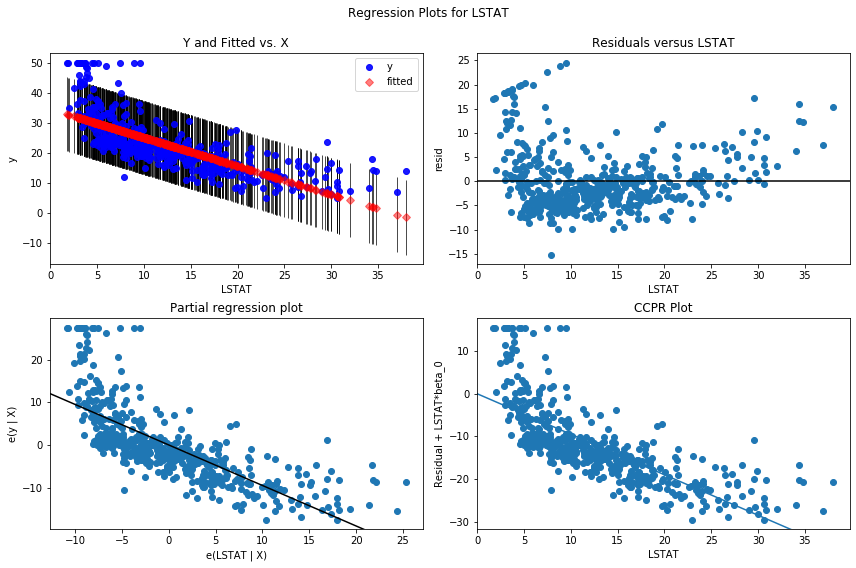

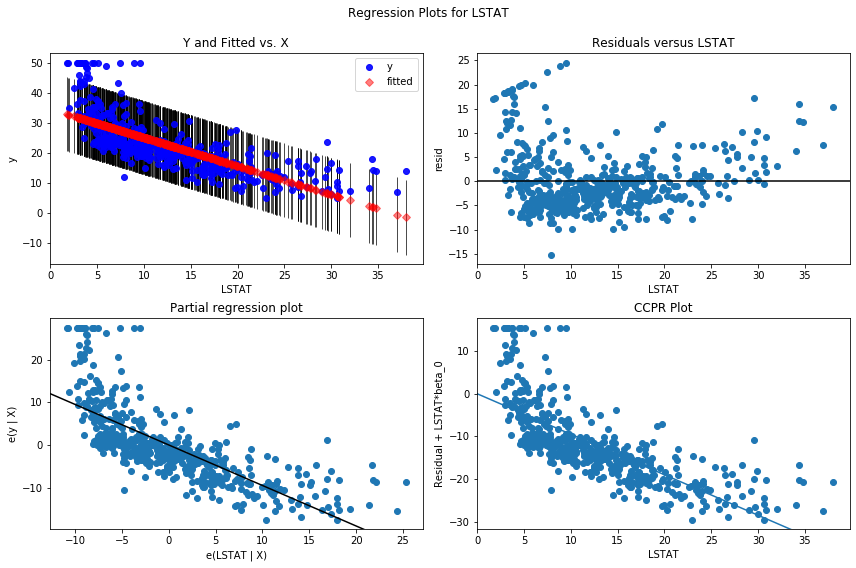

In [26]:
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(boston_lr_sm, 'LSTAT', fig=fig)